# Solving and Simulation

In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.interpolate as interp
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [2]:
# configure matplotlib output
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
col = mpl.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

In [3]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [4]:
# parameters
rho = 0.05 # discount rate
alpha = 0.3 # capital elasticity
delta = 0.1 # depreciation
theta = 1.0 # crra param

## Ramsey Model

In [5]:
# algorithm
S0 = 2**16 # max number of steps in perturbation simulation
S1 = 4096 # short simulation
K = 512 # size of capital grid
ptol = 1.0e-4 # initial displacement for perturbation simulation
dt_max = 1.0 # max time step in variable delt schemes

In [6]:
# steady state
k_ss = (alpha/(rho+delta))**(1.0/(1.0-alpha))
i_ss = delta*k_ss
y_ss = k_ss**alpha
c_ss = y_ss - i_ss

In [7]:
# grid it up
k_lo, k_hi = 0.01, 2.0*k_ss
k_grid = np.linspace(k_lo, k_hi, K)

In [8]:
def simulate_ramsey(k0, c0, k_lo=0, k_hi=None, gk_targ=0.001, dt=None, S=S0, direc=-1):
    # initial values
    k, c = k0, c0
    kpath, cpath = [k], [c]

    for t in range(S):
        # growth rates
        gk = k**(alpha-1) - delta - c/k
        gc = (1/theta)*(alpha*k**(alpha-1)-(rho+delta))

        # adaptive step size
        dt1 = direc*np.minimum(dt_max, gk_targ/np.abs(gk)) if dt is None else dt
        k *= 1 + dt1*gk
        c *= 1 + dt1*gc

        # store
        kpath.append(k)
        cpath.append(c)

        # terminal condition
        if k_lo is not None and k <= k_lo:
            break
        if k_hi is not None and k >= k_hi:
            break

    return np.array(kpath), np.array(cpath)

In [9]:
# generate upper and lower paths
kvec1, cvec1 = simulate_ramsey(k_ss-ptol, c_ss-ptol, k_lo, k_hi)
kvec2, cvec2 = simulate_ramsey(k_ss+ptol, c_ss+ptol, k_lo, k_hi)

# combined path
kvec = np.concatenate([kvec1[::-1], kvec2])
cvec = np.concatenate([cvec1[::-1], cvec2])

# interpolate
cpol = interp.interp1d(kvec, cvec)

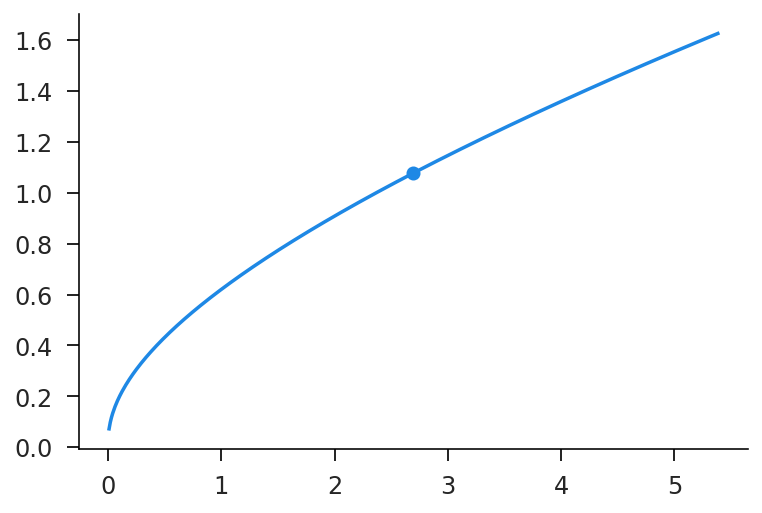

In [10]:
c_grid = cpol(k_grid)

# plot results
fig, ax = plt.subplots()
ax.plot(k_grid, c_grid);
ax.scatter([k_ss], [c_ss]);

In [11]:
def forward_ramsey(k0, cf, dt=0.01, S=S0):
    # initial values
    k, c = k0, cf(k0)
    kpath, cpath = [k], [c]

    for t in range(S):
        gk = k**(alpha-1) - delta - c/k

        k *= 1 + dt*gk
        c = cf(k)

        # store
        kpath.append(k)
        cpath.append(c)

    return np.array(kpath), np.array(cpath)

In [12]:
def solow_policy(s):
    return lambda k: (1-s)*k**alpha

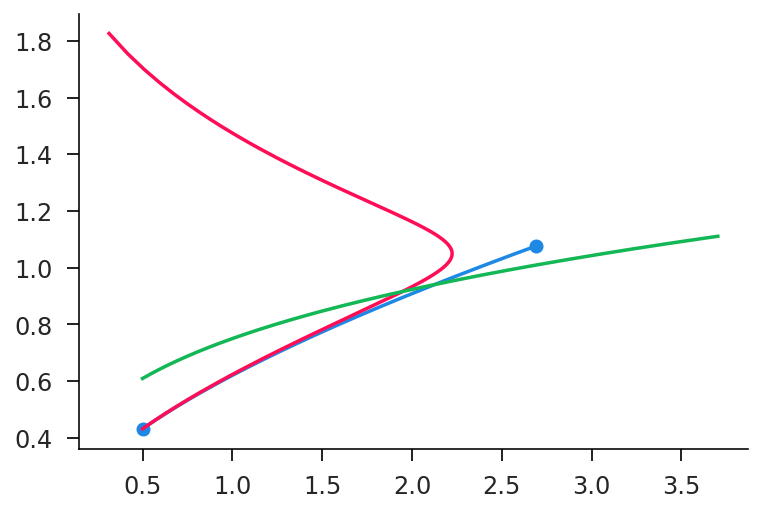

In [13]:
k0 = 0.5
c0 = float(cpol(k0))

csol = solow_policy(0.25)

dt = 0.1
kfwd, cfwd = forward_ramsey(k0, cpol, dt=dt, S=S1)
ksol, csol = forward_ramsey(k0, csol, dt=dt, S=S1)
ksim, csim = simulate_ramsey(k0, c0, dt=dt, k_lo=0.4, direc=1)

fig, ax = plt.subplots()
ax.plot(kfwd, cfwd);
ax.plot(ksim, csim);
ax.plot(ksol, csol);
ax.scatter([k0, k_ss], [c0, c_ss]);

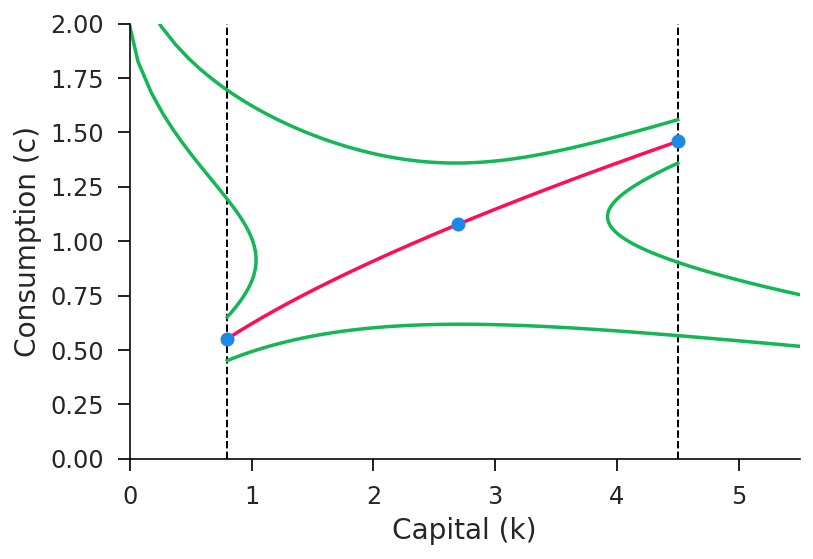

In [14]:
kv0 = [0.8, 4.5]
cv0 = cpol(kv0)
dt = 0.1
err = 0.1

fig, ax = plt.subplots()

for k0, c0 in zip(kv0, cv0):
    kfwd, cfwd = forward_ramsey(k0, cpol, dt=dt, S=S1)
    ksim1, csim1 = simulate_ramsey(k0, c0-err, dt=dt, k_hi=6.0, S=S1, direc=1)
    ksim2, csim2 = simulate_ramsey(k0, c0+err, dt=dt, k_hi=6.0, S=S1, direc=1)

    ax.plot(kfwd, cfwd, color=col[1]);
    ax.plot(ksim1, csim1, color=col[2]);
    ax.plot(ksim2, csim2, color=col[2]);
    ax.vlines(k0, 0, 2, color='k', linestyle='--', linewidth=1);
    
ax.scatter(kv0, cv0, color=col[0], zorder=3);
ax.scatter([k_ss], [c_ss], color=col[0], zorder=3);

ax.set_xlim(0, 5.5);
ax.set_ylim(0, 2);

ax.set_xlabel('Capital (k)');
ax.set_ylabel('Consumption (c)');

fig.savefig('')

## Exercise

1. Simulate a pre-announced policy change, such as a capital gains tax.

## Value Functions

In [17]:
from scipy.stats import norm

In [32]:
delt = 0.01
upd = 0.3
sig = norm.cdf
u = np.log
up = lambda x: 1/x

In [33]:
# grid it up
k_lo, k_hi = 0.1, 2.0*k_ss
k_grid = np.linspace(k_lo, k_hi, K)
k_diff = np.diff(k_grid)
y_grid = k_grid**alpha

In [34]:
val = 0.1*np.log(y_grid)
inv = np.zeros_like(k_grid)

for i in range(20000):
    adot = inv - delta*k_grid
    vala_p = np.r_[val[1:]-val[:-1],val[-1]-val[-2]]/np.r_[k_diff,k_diff[-1]]
    vala_n = np.r_[val[1]-val[0],val[1:]-val[:-1]]/np.r_[k_diff[0],k_diff]
    vala = sig(adot)*vala_p + sig(-adot)*vala_n

    inv_new = np.clip(y_grid - 1/vala, -0.3, 0.3)
    val_new = delt*u(y_grid-adot) + (1-delt*rho)*(val + delt*adot*vala)

    if i % 1000 == 0:
        print(i, np.max(np.abs(val_new-val)), np.max(np.abs(inv_new-inv)))
    
    val[:] = upd*val_new + (1-upd)*val
    inv[:] = upd*inv_new + (1-upd)*inv

0 0.007808185206204098 0.3
1000 0.006071060962073549 0.004450236104657002
2000 0.0034648240705306144 0.0016692161038684983
3000 0.002377111312211966 0.0007327849901518357
4000 0.00198306878519805 0.0003594220998388853
5000 0.001703314659178723 0.01638227962738137
6000 0.0014811314571891998 0.01569184306329975
7000 0.0012677902069144764 0.010382907978079909
8000 0.001080689607521279 0.009280588396433052
9000 0.0008875228779574584 0.013727966937251021
10000 0.0007350956255285368 0.019062391556063485
11000 0.0006206933540626736 0.0210034152205823
12000 0.0005300555109739591 0.024174109844333713
13000 0.00047360584883193724 0.025785521636063874
14000 0.000434970534637813 0.031116948135488876
15000 0.0006846406558613793 0.020463123143643347
16000 0.00043192543919490234 1.0742100179341602e-05
17000 0.0003737381115849203 7.228844879636487e-06
18000 0.00022794738030751382 3.9797542298602995e-06
19000 0.00017928251678189788 3.3057464226115413e-06


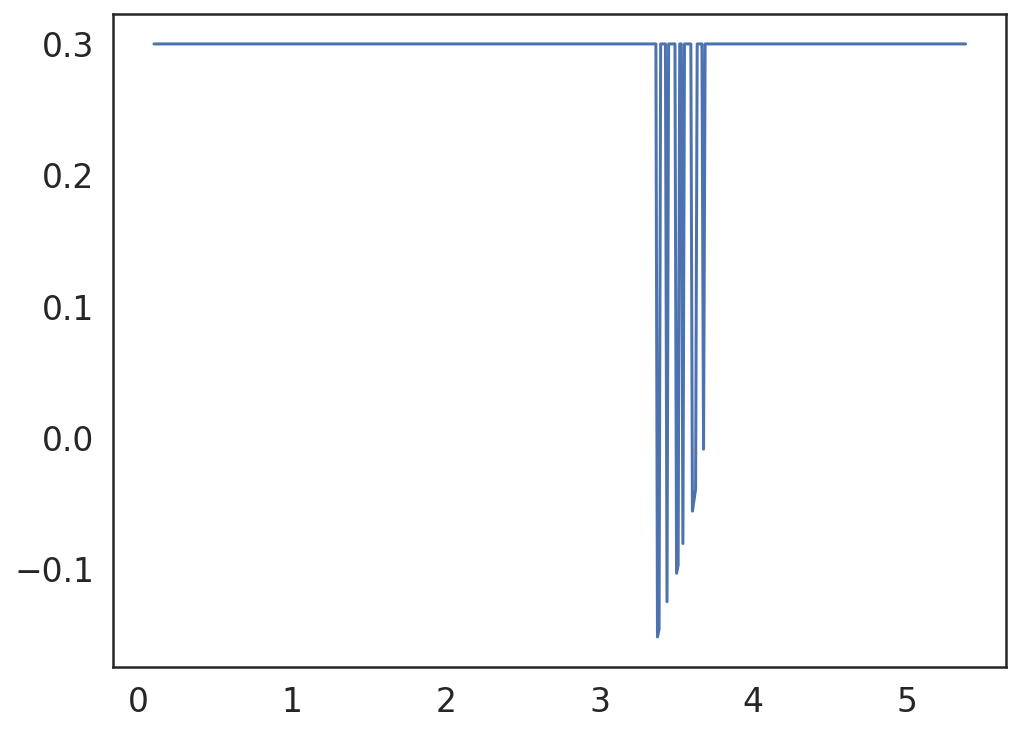

In [35]:
plt.plot(k_grid, inv);